# Demonstration of Kandinsky parallelization
**by [Maria Kovaleva](https://t.me/makovka2000) for Practical ML Conf 2025**

In [2]:
from kandinsky import get_T2V_pipeline
from IPython.display import Video

/home/jovyan/.mlspace/envs/vladimir-cu12.6-torch2.6.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Video

In [3]:
!python -m torch.distributed.launch --nnodes 1 --nproc-per-node 1 test_pml.py --path "./test1.mp4"

/home/jovyan/.mlspace/envs/vladimir-cu12.6-torch2.6.0/lib/python3.10/site-packages/torch/distributed/launch.py:207: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  main()
Loading checkpoint shards: 100%|██████████████████| 5/5 [00:00<00:00,  5.82it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|███████████████████████████████████████████| 50/50 [03:29<00:00,  4.18s/it]
TIME ELA

In [4]:
Video("./test1.mp4")

In [1]:
!python -m torch.distributed.launch --nnodes 1 --nproc-per-node 2 test_pml.py --path "./test2.mp4"

/home/jovyan/.mlspace/envs/vladimir-cu12.6-torch2.6.0/lib/python3.10/site-packages/torch/distributed/launch.py:207: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  main()
W1003 04:09:50.529000 72675 site-packages/torch/distributed/run.py:766] 
W1003 04:09:50.529000 72675 site-packages/torch/distributed/run.py:766] *****************************************
W1003 04:09:50.529000 72675 site-packages/torch/distributed/run.py:766] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1003 04:09:50.529000 726

In [5]:
Video("./test2.mp4")

In [6]:
!python -m torch.distributed.launch --nnodes 1 --nproc-per-node 4 test_pml.py --path "./test3.mp4"

/home/jovyan/.mlspace/envs/vladimir-cu12.6-torch2.6.0/lib/python3.10/site-packages/torch/distributed/launch.py:207: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  main()
W1003 04:18:34.934000 76582 site-packages/torch/distributed/run.py:766] 
W1003 04:18:34.934000 76582 site-packages/torch/distributed/run.py:766] *****************************************
W1003 04:18:34.934000 76582 site-packages/torch/distributed/run.py:766] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1003 04:18:34.934000 765

In [7]:
Video("./test3.mp4")

In [8]:
pipe = get_T2V_pipeline(
    device_map={"dit": "cuda:0", "vae": "cuda:1", "text_embedder": "cuda:2"},
    conf_path="./configs/config_pml.yaml"
) 

Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
out = pipe("a cat in a red hat", time_length=10, width=768, height=512, guidance_weight=5.0, num_steps=50, scheduler_scale=10, save_path='./test.mp4')
out.shape

100%|██████████| 50/50 [11:56<00:00, 14.32s/it]


torch.Size([1, 3, 241, 512, 768])

In [13]:
Video('./test.mp4')

# Параллельный инференс

## Запуск
В целом за распределенные операции в pytorch отвечает модуль **torch.distributed** 

И чтобы в целом чтобы запустить какой либо скрипт на нескольких ГПУ-шках нам потребуется этот модуль запустить, из терминала это делается так:

```python -m torch.distributed.launch --nnodes m --nproc-per-node n your_script.py```

## В файле kandinsky/\_\_init__.py

В самом коде надо создать либо группу процессов:

```python
torch.distributed.init_process_group()
```

Либо сетку девайсов:

```python
torch.distributed.device_mesh.init_device_mesh()
```

Мы используем второй подход:

```python
device_mesh = init_device_mesh(
    "cuda", (world_size,), mesh_dim_names=("tensor_parallel",)
)
```

Далее перейдем к распараллеливанию самой модели. Делается это с помощью функции **parallelize_dit** одной строчкой:

```python
dit = parallelize_dit(dit, device_mesh["tensor_parallel"])
```

## В файле kandinsky/models/parallelize.py

В функции parallelize_dit и происходит распараллеливание модели. Рассмотрим инструменты которые для этого используются

```python
from torch.distributed._tensor import Replicate
from torch.distributed.tensor.parallel import (
    ColwiseParallel,
    PrepareModuleInput,
    RowwiseParallel,
    SequenceParallel,
    parallelize_module,
)
```
* **ColwiseParallel** and **RowwiseParallel**: Шардируют nn.Linear и nn.Embedding по столбцам или строкам соответсвенно

* **SequenceParallel**: Выполняем распределенное вычисление nn.LayerNorm, nn.Dropout, RMSNorm, и др.

* **PrepareModuleInput** and **PrepareModuleOutput**: Преобразуют входы/выходы модуля разбивая их по нужным осям
  
* **parallelize_module**: основная функция параллелизации модулей. В нее нужно передать модуль, сетку девайсов, и план параллелизации

Собсвенно практически вся наша работа по распараллеливанию модели сводится к написанию правильного плана для параллелизации соответсвующих модулей.




### Устройство модели
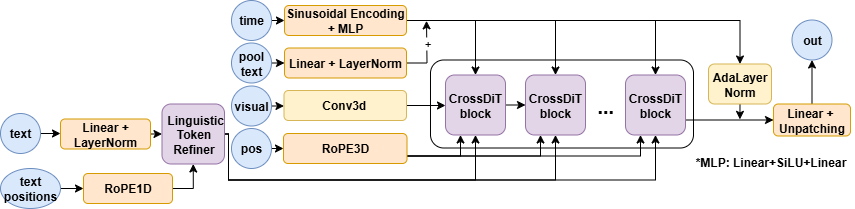

Самыми простыми для параллелизации являются просто линейные слои и полносвязные части модели. Как мы уже обсудили их мы будем оборачивать в **ColwiseParallel** и/или **RowwiseParallel**. Такими частями в нашей модели являются модуль **model.time_embeddings** который является MLP и слои **model.text_embeddings**, **model.pooled_text_embeddings**, **model.visual_embeddings** которые состоят из линейных слоев и нормировок.

In [14]:
pipe.dit.time_embeddings

TimeEmbeddings(
  (in_layer): Linear(in_features=1792, out_features=512, bias=True)
  (activation): SiLU()
  (out_layer): Linear(in_features=512, out_features=512, bias=True)
)

In [15]:
pipe.dit.text_embeddings, pipe.dit.pooled_text_embeddings, pipe.dit.visual_embeddings

(TextEmbeddings(
   (in_layer): Linear(in_features=3584, out_features=1792, bias=True)
   (norm): LayerNorm((1792,), eps=1e-05, elementwise_affine=True)
 ),
 TextEmbeddings(
   (in_layer): Linear(in_features=768, out_features=512, bias=True)
   (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
 ),
 VisualEmbeddings(
   (in_layer): Linear(in_features=132, out_features=1792, bias=True)
 ))

Как это параллелится в коде:
```python
plan = {
    "in_layer": ColwiseParallel(),
    "out_layer": RowwiseParallel(
        output_layouts=Replicate(),
    ),
}
parallelize_module(model.time_embeddings, tp_mesh, plan)

plan = {
    "in_layer": ColwiseParallel(
        output_layouts=Replicate(),
    )
}
parallelize_module(model.text_embeddings, tp_mesh, plan)
parallelize_module(model.pooled_text_embeddings, tp_mesh, plan)
parallelize_module(model.visual_embeddings, tp_mesh, plan)
```

Дальше самое интересное, как параллелить блок трансформера.

### Устройство блока

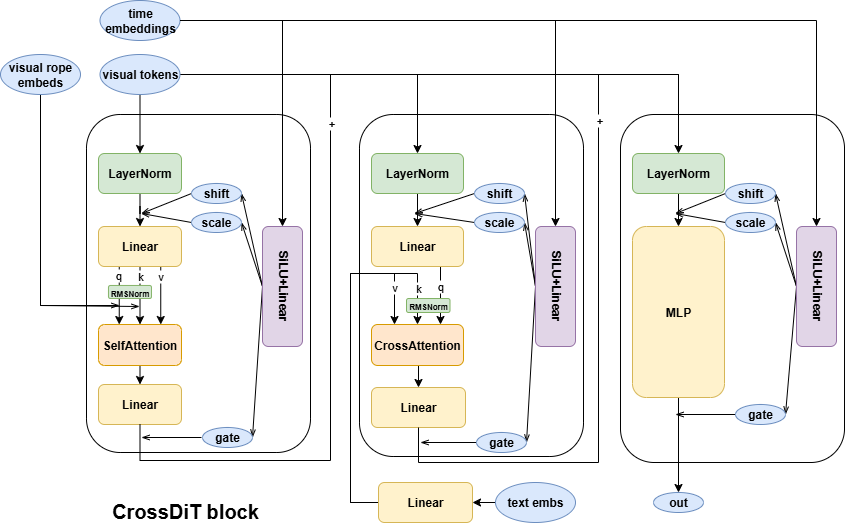

In [16]:
pipe.dit.visual_transformer_blocks[0]

TransformerDecoderBlock(
  (visual_modulation): Modulation(
    (activation): SiLU()
    (out_layer): Linear(in_features=512, out_features=16128, bias=True)
  )
  (self_attention_norm): LayerNorm((1792,), eps=1e-05, elementwise_affine=False)
  (self_attention): MultiheadSelfAttention(
    (to_query): Linear(in_features=1792, out_features=1792, bias=True)
    (to_key): Linear(in_features=1792, out_features=1792, bias=True)
    (to_value): Linear(in_features=1792, out_features=1792, bias=True)
    (query_norm): RMSNorm((64,), eps=None, elementwise_affine=True)
    (key_norm): RMSNorm((64,), eps=None, elementwise_affine=True)
  )
  (out_layer_self): Linear(in_features=1792, out_features=1792, bias=True)
  (cross_attention_norm): LayerNorm((1792,), eps=1e-05, elementwise_affine=False)
  (cross_attention): MultiheadCrossAttention(
    (to_query): Linear(in_features=1792, out_features=1792, bias=True)
    (to_key): Linear(in_features=1792, out_features=1792, bias=True)
    (to_value): Linear

Как это параллелить? Давйте рассмотрим алгорим Megatron-LM

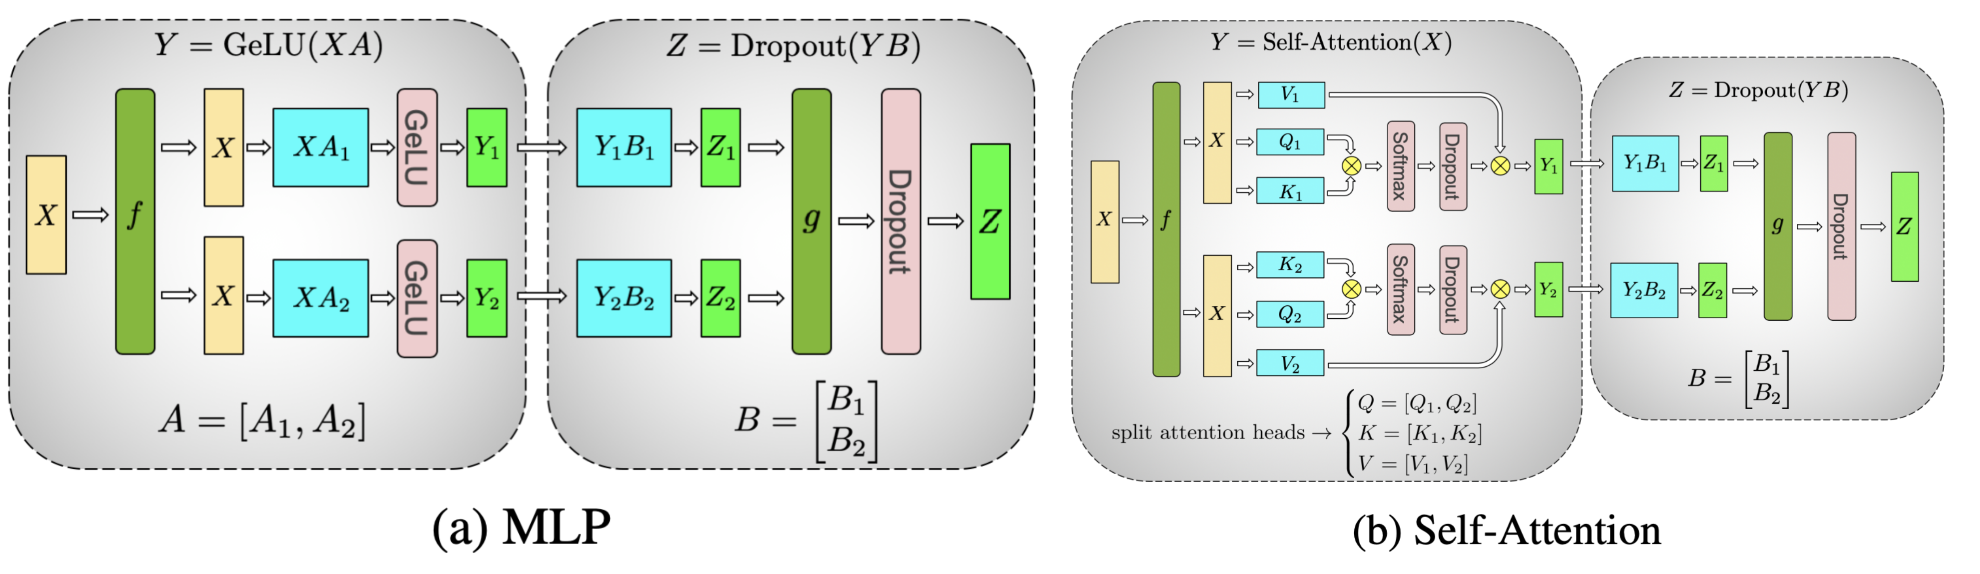

Рассмотрим, например, параллелизацию self-attention:
```python
"self_attention_norm": SequenceParallel(
    sequence_dim=0, use_local_output=True
),
"self_attention.to_query": ColwiseParallel(
    input_layouts=Replicate(),
),
"self_attention.to_key": ColwiseParallel(
    input_layouts=Replicate(),
),
"self_attention.to_value": ColwiseParallel(
    input_layouts=Replicate(),
),
"self_attention.query_norm": SequenceParallel(
    sequence_dim=0, use_local_output=True
),
"self_attention.key_norm": SequenceParallel(
    sequence_dim=0, use_local_output=True
),
"out_layer_self": RowwiseParallel(
    output_layouts=Replicate(),
),
```

Важный момент: эффективное количество голов трансформера уменьшается, так как на каждую карту будет считаться только своя часть голов

```python
self_attn = visual_transformer_block.self_attention
self_attn.num_heads = self_attn.num_heads // tp_mesh.size()
```